In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import torch
from tqdm import tqdm
import scipy
from glob import glob
from dca.cov_util import calc_cross_cov_mats_from_data, calc_pi_from_cross_cov_mats
from neurosim.models.ssr import StateSpaceRealization as SSR
from dca_research.kca import calc_mmse_from_cross_cov_mats
from dca_research.kca import KalmanComponentsAnalysis as KCA
from dca_research.kca import SparseKCA as SKCA

### Similarity Invariance or lake thereof of KCA

In [10]:
# Is the KCA objective function invariant under similarity transformations?
A = np.random.normal(scale = 1/(2 * np.sqrt(10)), size=(10, 10))
while max(np.abs(np.linalg.eigvals(A)) > 0.99):
    A = np.random.normal(scale = 1/(2 * np.sqrt(10)), size=(10, 10))    

In [11]:
ssr = SSR(A, B=np.eye(A.shape[0]), C = np.eye(A.shape[0]))

In [12]:
y = ssr.trajectory(int(1e5))

In [13]:
ccm = calc_cross_cov_mats_from_data(y, 5)

In [14]:
V = scipy.stats.ortho_group.rvs(10)[:, 0:2]

In [15]:
V2 = scipy.stats.ortho_group.rvs(10)

In [19]:
from copy import deepcopy

In [21]:
V3 = deepcopy(V)

In [26]:
V3

array([[ 0.10124393, -0.39173776],
       [ 0.9670387 ,  0.57752922],
       [ 0.32898661, -0.27115726],
       [ 0.11032081, -0.10207836],
       [ 0.30354118, -0.23080317],
       [ 0.11692019, -0.36024815],
       [ 0.12913462,  0.00611825],
       [-0.05152126,  0.2413429 ],
       [ 0.30259463, -0.3486185 ],
       [ 0.73483445, -0.25726981]])

In [25]:
V

array([[ 0.0749955 , -0.39173776],
       [ 0.71632496,  0.57752922],
       [ 0.24369379, -0.27115726],
       [ 0.08171912, -0.10207836],
       [ 0.22484532, -0.23080317],
       [ 0.08660755, -0.36024815],
       [ 0.09565528,  0.00611825],
       [-0.0381639 ,  0.2413429 ],
       [ 0.22414417, -0.3486185 ],
       [ 0.54432181, -0.25726981]])

In [23]:
V3[:, 0] *= 1.35

In [28]:
calc_mmse_from_cross_cov_mats(torch.tensor(ccm), torch.tensor(V3))

tensor(12.8358, dtype=torch.float64)

### Is the sparse Kalman filter problem scale invariant?

In [ ]:
B1 = np.eye(A.shape[0])
B2 = scipy.stats.ortho)group.rvs()

In [14]:
# If the loss is essentially the observability gramian, then no...

### Hoyer gradients

In [57]:
v = torch.randn(10)
v.requires_grad = True

In [58]:
hoyer = torch.norm(v, 1)**2/torch.norm(v, 2)**2

In [59]:
hoyer.backward()

In [60]:
v.grad

tensor([-1.2749, -0.4345, -1.4848, -0.6395, -1.3029,  1.5723, -1.2522,  1.6680,
        -1.0039,  1.0056])

In [61]:
2 * torch.sign(v) * torch.norm(v, 1)/(torch.norm(v, 2)**4) * (torch.norm(v, 2)**2 - torch.abs(v) * torch.norm(v, 1))

tensor([-1.2749, -0.4345, -1.4848, -0.6395, -1.3029,  1.5723, -1.2522,  1.6680,
        -1.0039,  1.0056], grad_fn=<MulBackward0>)

### KCA vs. sparse KCA

In [3]:
# Is the KCA objective function invariant under similarity transformations?
A = np.random.normal(scale = 1/(2 * np.sqrt(10)), size=(10, 10))
while max(np.abs(np.linalg.eigvals(A)) > 0.99):
    A = np.random.normal(scale = 1/(2 * np.sqrt(10)), size=(10, 10))    

In [4]:
ssr = SSR(A, B=np.eye(A.shape[0]), C = np.eye(A.shape[0]))

In [5]:
y = ssr.trajectory(int(1e5))

In [6]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import calc_loadings
from tqdm import tqdm

In [7]:
kcamodel = KCA(d=2, T=3)
kcamodel.estimate_data_statistics(y, 5)
kcav, kca_mmse = kcamodel._fit_projection()

In [8]:
alpha = np.linspace(0, 2, 20)
rho1 = np.linspace(1, 20, 5)
rho2 = np.linspace(1, 20, 5)

mmse_loss = np.zeros((alpha.size, rho1.size, rho2.size, 2))
loadings = np.zeros((alpha.size, rho1.size, rho2.size, 2, y.shape[1]))

for i, alpha_ in tqdm(enumerate(alpha)):
    for j, rho1_ in enumerate(rho1):
        for k, rho2_ in enumerate(rho2):
            skca = SKCA(d=2, T=3, verbose=False, alpha=alpha_, rho1=rho1_, rho2=rho2_, 
                        ADMM_iterations=200)            

            # Alternatively using direct descent
            skca2 = SKCA(d=2, T=3, verbose=False, alpha=alpha_, opt_method='direct')
            skca.cross_covs = kcamodel.cross_covs
            skca2.cross_covs = kcamodel.cross_covs
            V, W, U, L1, L2, loss_series = skca._fit_projection()
            mmse_loss[i, j, k, 0] = loss_series[-1]
            loadings[i, j, k, 0] = calc_loadings(V.detach().numpy())
            
            V, loss_series = skca2._fit_projection()
            mmse_loss[i, j, k, 1] = loss_series[-1]
            loadings[i, j, k, 1] = calc_loadings(V)

0it [00:00, ?it/s]

Overall Loss: 12.783873, MMSE Loss: 11.538347
Overall Loss: 12.314924, MMSE Loss: 11.375078
Overall Loss: 13.466448, MMSE Loss: 11.216587
Overall Loss: 17.192644, MMSE Loss: 11.311078
Overall Loss: 13.883553, MMSE Loss: 11.116719
Overall Loss: 15.823400, MMSE Loss: 11.312900
Overall Loss: 14.601530, MMSE Loss: 11.232109
Overall Loss: 14.168915, MMSE Loss: 11.205853
Overall Loss: 14.509819, MMSE Loss: 11.122924
Overall Loss: 14.276088, MMSE Loss: 11.132914
Overall Loss: 13.981110, MMSE Loss: 11.095085
Overall Loss: 14.103069, MMSE Loss: 11.092978
Overall Loss: 14.120681, MMSE Loss: 11.086709
Overall Loss: 13.999520, MMSE Loss: 11.086415
Overall Loss: 13.953761, MMSE Loss: 11.085311
Overall Loss: 13.994337, MMSE Loss: 11.085294
Overall Loss: 13.972917, MMSE Loss: 11.084966
Overall Loss: 13.939487, MMSE Loss: 11.084965
Overall Loss: 13.949283, MMSE Loss: 11.084961
Overall Loss: 13.962921, MMSE Loss: 11.084961
Overall Loss: 13.956120, MMSE Loss: 11.084954
Overall Loss: 13.948144, MMSE Loss

1it [00:33, 33.42s/it]

Overall Loss: 11.090384, MMSE Loss: 11.090380
Overall Loss: 11.090292, MMSE Loss: 11.090287
Overall Loss: 11.090201, MMSE Loss: 11.090197
Overall Loss: 11.090112, MMSE Loss: 11.090108
Overall Loss: 11.090025, MMSE Loss: 11.090021
Overall Loss: 11.089940, MMSE Loss: 11.089936
Overall Loss: 11.089856, MMSE Loss: 11.089853
Overall Loss: 11.089774, MMSE Loss: 11.089771
Overall Loss: 11.089694, MMSE Loss: 11.089691
Overall Loss: 11.089615, MMSE Loss: 11.089612
Overall Loss: 11.089538, MMSE Loss: 11.089535
Overall Loss: 11.089462, MMSE Loss: 11.089460
Overall Loss: 11.089388, MMSE Loss: 11.089386
Overall Loss: 11.089315, MMSE Loss: 11.089313
Overall Loss: 11.089244, MMSE Loss: 11.089242
Overall Loss: 11.089174, MMSE Loss: 11.089173
Overall Loss: 11.089105, MMSE Loss: 11.089104
Overall Loss: 11.089038, MMSE Loss: 11.089037
Overall Loss: 13.606388, MMSE Loss: 11.612965
Overall Loss: 12.919772, MMSE Loss: 11.382106
Overall Loss: 13.575597, MMSE Loss: 11.150300
Overall Loss: 17.156123, MMSE Loss

2it [01:08, 34.14s/it]

Overall Loss: 11.599464, MMSE Loss: 11.305001
Overall Loss: 11.599096, MMSE Loss: 11.304779
Overall Loss: 11.598822, MMSE Loss: 11.304579
Overall Loss: 11.598421, MMSE Loss: 11.304370
Overall Loss: 11.598051, MMSE Loss: 11.304144
Overall Loss: 11.597752, MMSE Loss: 11.303939
Overall Loss: 11.597366, MMSE Loss: 11.303724
Overall Loss: 11.597052, MMSE Loss: 11.303517
Overall Loss: 11.596680, MMSE Loss: 11.303304
Overall Loss: 11.596309, MMSE Loss: 11.303074
Overall Loss: 11.596020, MMSE Loss: 11.302867
Overall Loss: 11.595634, MMSE Loss: 11.302652
Overall Loss: 11.595273, MMSE Loss: 11.302424
Overall Loss: 11.594971, MMSE Loss: 11.302219
Overall Loss: 11.594594, MMSE Loss: 11.302005
Overall Loss: 11.594228, MMSE Loss: 11.301779
Overall Loss: 11.593917, MMSE Loss: 11.301575
Overall Loss: 11.593540, MMSE Loss: 11.301362
Overall Loss: 11.593180, MMSE Loss: 11.301134
Overall Loss: 15.006549, MMSE Loss: 11.749112
Overall Loss: 13.740723, MMSE Loss: 11.475694
Overall Loss: 16.041638, MMSE Loss

3it [01:44, 35.09s/it]

Overall Loss: 16.172538, MMSE Loss: 11.561201
Overall Loss: 14.164825, MMSE Loss: 11.332606
Overall Loss: 15.264648, MMSE Loss: 11.150419
Overall Loss: 18.834181, MMSE Loss: 11.505256
Overall Loss: 16.987898, MMSE Loss: 11.238898
Overall Loss: 18.360791, MMSE Loss: 11.374626
Overall Loss: 18.459359, MMSE Loss: 11.276113
Overall Loss: 20.542295, MMSE Loss: 11.496985
Overall Loss: 19.595919, MMSE Loss: 11.450934
Overall Loss: 19.878933, MMSE Loss: 11.464937
Overall Loss: 18.299619, MMSE Loss: 11.404872
Overall Loss: 18.161464, MMSE Loss: 11.456280
Overall Loss: 17.352521, MMSE Loss: 11.478924
Overall Loss: 17.091842, MMSE Loss: 11.219602
Overall Loss: 17.704166, MMSE Loss: 11.502640
Overall Loss: 19.308079, MMSE Loss: 11.429250
Overall Loss: 18.003096, MMSE Loss: 11.473120
Overall Loss: 18.852485, MMSE Loss: 11.605121
Overall Loss: 18.287345, MMSE Loss: 11.286614
Overall Loss: 18.443622, MMSE Loss: 11.282160
Overall Loss: 19.472539, MMSE Loss: 11.306596
Overall Loss: 20.059602, MMSE Loss

4it [02:23, 36.87s/it]

Overall Loss: 16.999123, MMSE Loss: 11.662910
Overall Loss: 14.340566, MMSE Loss: 11.496532
Overall Loss: 14.715272, MMSE Loss: 11.334095
Overall Loss: 18.376625, MMSE Loss: 11.274512
Overall Loss: 18.176411, MMSE Loss: 11.247694
Overall Loss: 18.824644, MMSE Loss: 11.458410
Overall Loss: 17.942625, MMSE Loss: 11.428690
Overall Loss: 17.589821, MMSE Loss: 11.588916
Overall Loss: 17.111196, MMSE Loss: 11.360812
Overall Loss: 16.307748, MMSE Loss: 11.368664
Overall Loss: 16.929929, MMSE Loss: 11.362265
Overall Loss: 16.080865, MMSE Loss: 11.313658
Overall Loss: 16.230821, MMSE Loss: 11.296099
Overall Loss: 15.591568, MMSE Loss: 11.213635
Overall Loss: 14.879453, MMSE Loss: 11.318374
Overall Loss: 15.055951, MMSE Loss: 11.277801
Overall Loss: 15.166494, MMSE Loss: 11.282741
Overall Loss: 15.125077, MMSE Loss: 11.222368
Overall Loss: 15.662815, MMSE Loss: 11.324323
Overall Loss: 15.739807, MMSE Loss: 11.299595
Overall Loss: 16.105859, MMSE Loss: 11.296402
Overall Loss: 15.957765, MMSE Loss

5it [03:03, 37.79s/it]

Overall Loss: 19.882583, MMSE Loss: 11.745669
Overall Loss: 15.844118, MMSE Loss: 11.470943
Overall Loss: 17.467345, MMSE Loss: 11.277798
Overall Loss: 20.380775, MMSE Loss: 11.764001
Overall Loss: 18.672915, MMSE Loss: 11.413437
Overall Loss: 20.827300, MMSE Loss: 11.367991
Overall Loss: 20.098801, MMSE Loss: 11.316869
Overall Loss: 20.834341, MMSE Loss: 11.684849
Overall Loss: 20.250722, MMSE Loss: 11.412101
Overall Loss: 22.031636, MMSE Loss: 11.571080
Overall Loss: 19.909815, MMSE Loss: 11.634026
Overall Loss: 20.324014, MMSE Loss: 11.470829
Overall Loss: 19.103645, MMSE Loss: 11.542426
Overall Loss: 18.916425, MMSE Loss: 11.450122
Overall Loss: 19.088545, MMSE Loss: 11.497740
Overall Loss: 18.814032, MMSE Loss: 11.332594
Overall Loss: 19.116418, MMSE Loss: 11.319049
Overall Loss: 20.504621, MMSE Loss: 11.163674
Overall Loss: 20.426708, MMSE Loss: 11.200329
Overall Loss: 24.108164, MMSE Loss: 11.388945
Overall Loss: 22.535532, MMSE Loss: 11.417582
Overall Loss: 24.021723, MMSE Loss

6it [03:43, 38.63s/it]

Overall Loss: 26.043978, MMSE Loss: 11.569474
Overall Loss: 16.659139, MMSE Loss: 11.413227
Overall Loss: 19.481417, MMSE Loss: 11.236390
Overall Loss: 22.695921, MMSE Loss: 11.810640
Overall Loss: 21.191486, MMSE Loss: 11.585877
Overall Loss: 21.501862, MMSE Loss: 11.707482
Overall Loss: 20.541147, MMSE Loss: 11.785270
Overall Loss: 20.618603, MMSE Loss: 11.340505
Overall Loss: 25.087588, MMSE Loss: 11.517647
Overall Loss: 24.474981, MMSE Loss: 11.582714
Overall Loss: 23.032440, MMSE Loss: 11.651505
Overall Loss: 22.900515, MMSE Loss: 11.418554
Overall Loss: 26.134760, MMSE Loss: 11.433863
Overall Loss: 24.945619, MMSE Loss: 11.620893
Overall Loss: 20.680935, MMSE Loss: 11.324617
Overall Loss: 20.618476, MMSE Loss: 11.436821
Overall Loss: 25.705071, MMSE Loss: 11.485356
Overall Loss: 23.385195, MMSE Loss: 11.343644
Overall Loss: 27.192891, MMSE Loss: 11.370342
Overall Loss: 25.653072, MMSE Loss: 11.325737
Overall Loss: 31.414475, MMSE Loss: 11.285685
Overall Loss: 30.276266, MMSE Loss

7it [04:26, 40.03s/it]

Overall Loss: 12.756367, MMSE Loss: 11.705624
Overall Loss: 24.619417, MMSE Loss: 11.705742
Overall Loss: 17.311949, MMSE Loss: 11.434482
Overall Loss: 18.813813, MMSE Loss: 11.362691
Overall Loss: 24.654998, MMSE Loss: 11.412571
Overall Loss: 22.344876, MMSE Loss: 11.727191
Overall Loss: 27.974233, MMSE Loss: 11.332602
Overall Loss: 35.144673, MMSE Loss: 11.366181
Overall Loss: 34.814039, MMSE Loss: 11.235464
Overall Loss: inf, MMSE Loss: 11.242778
Overall Loss: 32.744582, MMSE Loss: 11.247032
Overall Loss: 30.264519, MMSE Loss: 11.284366
Overall Loss: 26.178680, MMSE Loss: 11.449117
Overall Loss: 28.159521, MMSE Loss: 11.442346
Overall Loss: 31.457512, MMSE Loss: 11.228317
Overall Loss: 23.899618, MMSE Loss: 11.315394
Overall Loss: 22.010604, MMSE Loss: 11.433040
Overall Loss: 24.347704, MMSE Loss: 11.362100
Overall Loss: 28.721952, MMSE Loss: 11.412683
Overall Loss: 72.973467, MMSE Loss: 11.341583
Overall Loss: 123.274548, MMSE Loss: 11.292749
Overall Loss: 1102.425817, MMSE Loss: 1

8it [05:10, 41.31s/it]

Overall Loss: 30.490585, MMSE Loss: 11.414324
Overall Loss: 17.481685, MMSE Loss: 11.281857
Overall Loss: 18.313894, MMSE Loss: 11.235442
Overall Loss: 26.604221, MMSE Loss: 11.497604
Overall Loss: 26.868601, MMSE Loss: 11.705049
Overall Loss: 32.617477, MMSE Loss: 11.829515
Overall Loss: 36.610536, MMSE Loss: 11.347662
Overall Loss: 26.641257, MMSE Loss: 11.308545
Overall Loss: 21.418097, MMSE Loss: 11.290189
Overall Loss: 23.406491, MMSE Loss: 11.346514
Overall Loss: 30.118112, MMSE Loss: 11.252953
Overall Loss: 28.599494, MMSE Loss: 11.292541
Overall Loss: 59.598840, MMSE Loss: 11.193817
Overall Loss: 42.270484, MMSE Loss: 11.338282
Overall Loss: 61.240422, MMSE Loss: 11.315101
Overall Loss: 49.354048, MMSE Loss: 11.264867
Overall Loss: 35.975712, MMSE Loss: 11.178608
Overall Loss: 31.563251, MMSE Loss: 11.243931
Overall Loss: 33.036067, MMSE Loss: 11.198560
Overall Loss: 30.797042, MMSE Loss: 11.223862
Overall Loss: 28.059690, MMSE Loss: 11.292934
Overall Loss: 22.986371, MMSE Loss

9it [05:53, 41.80s/it]

Overall Loss: 60.043142, MMSE Loss: 11.494911
Overall Loss: 19.956476, MMSE Loss: 11.227607
Overall Loss: 21.030365, MMSE Loss: 11.256022
Overall Loss: 42.788275, MMSE Loss: 11.667817
Overall Loss: inf, MMSE Loss: 11.265772
Overall Loss: 37.772299, MMSE Loss: 11.682218
Overall Loss: 31.584625, MMSE Loss: 11.459624
Overall Loss: 99.752815, MMSE Loss: 11.235537
Overall Loss: 76.398040, MMSE Loss: 11.160236
Overall Loss: 32.924697, MMSE Loss: 11.227851
Overall Loss: 28.337768, MMSE Loss: 11.314617
Overall Loss: 32.807668, MMSE Loss: 11.249056
Overall Loss: 43.398176, MMSE Loss: 11.190976
Overall Loss: 28.003882, MMSE Loss: 11.285531
Overall Loss: 50.934477, MMSE Loss: 11.216934
Overall Loss: 34.323996, MMSE Loss: 11.259640
Overall Loss: 57.957100, MMSE Loss: 11.218148
Overall Loss: 30.526212, MMSE Loss: 11.222279
Overall Loss: 45.488451, MMSE Loss: 11.274390
Overall Loss: 31.165534, MMSE Loss: 11.221733
Overall Loss: 213.452753, MMSE Loss: 11.264516
Overall Loss: 29.583171, MMSE Loss: 11.

10it [06:34, 41.59s/it]

Overall Loss: 13.374801, MMSE Loss: 11.785397
Overall Loss: 13.373718, MMSE Loss: 11.783148
Overall Loss: 13.372625, MMSE Loss: 11.780910
Overall Loss: 13.371524, MMSE Loss: 11.778684
Overall Loss: 13.370414, MMSE Loss: 11.776470
Overall Loss: 13.369296, MMSE Loss: 11.774268
Overall Loss: 13.368169, MMSE Loss: 11.772079
Overall Loss: 13.367033, MMSE Loss: 11.769903
Overall Loss: 13.365888, MMSE Loss: 11.767741
Overall Loss: 13.364735, MMSE Loss: 11.765592
Overall Loss: 13.363572, MMSE Loss: 11.763458
Overall Loss: 13.362401, MMSE Loss: 11.761338
Overall Loss: 13.361221, MMSE Loss: 11.759233
Overall Loss: 13.360032, MMSE Loss: 11.757144
Overall Loss: 57.410090, MMSE Loss: 11.403699
Overall Loss: 22.244487, MMSE Loss: 11.259368
Overall Loss: 22.624365, MMSE Loss: 11.198042
Overall Loss: 40.463660, MMSE Loss: 11.496002
Overall Loss: inf, MMSE Loss: 11.349341
Overall Loss: inf, MMSE Loss: 11.447396
Overall Loss: 33.236415, MMSE Loss: 11.236263
Overall Loss: 35.811684, MMSE Loss: 11.302862


11it [07:17, 41.90s/it]

Overall Loss: 308.395992, MMSE Loss: 11.538004
Overall Loss: 24.998561, MMSE Loss: 11.277602
Overall Loss: 23.509945, MMSE Loss: 11.272238
Overall Loss: 51.852509, MMSE Loss: 11.801168
Overall Loss: inf, MMSE Loss: 11.221629
Overall Loss: 85.794024, MMSE Loss: 11.306374
Overall Loss: 34.468855, MMSE Loss: 11.214227
Overall Loss: 94.262914, MMSE Loss: 11.130505
Overall Loss: 170.160150, MMSE Loss: 11.245415
Overall Loss: inf, MMSE Loss: 11.408422
Overall Loss: 51.949688, MMSE Loss: 11.204152
Overall Loss: 32.128454, MMSE Loss: 11.192871
Overall Loss: 44.673185, MMSE Loss: 11.151885
Overall Loss: 48.351389, MMSE Loss: 11.213443
Overall Loss: 37.462717, MMSE Loss: 11.244469
Overall Loss: 44.561680, MMSE Loss: 11.523263
Overall Loss: 31.854786, MMSE Loss: 11.286451
Overall Loss: 46.987206, MMSE Loss: 11.265358
Overall Loss: inf, MMSE Loss: 11.268631
Overall Loss: inf, MMSE Loss: 11.222525
Overall Loss: 47.292313, MMSE Loss: 11.218553
Overall Loss: inf, MMSE Loss: 11.307712
Overall Loss: in

12it [07:59, 41.97s/it]

Overall Loss: 223.091015, MMSE Loss: 11.616236
Overall Loss: 27.724459, MMSE Loss: 11.311794
Overall Loss: 24.809828, MMSE Loss: 11.302097
Overall Loss: 41.327408, MMSE Loss: 11.468452
Overall Loss: inf, MMSE Loss: 11.208036
Overall Loss: inf, MMSE Loss: 11.348587
Overall Loss: 60.283926, MMSE Loss: 11.189485
Overall Loss: 190.688142, MMSE Loss: 11.422207
Overall Loss: inf, MMSE Loss: 11.111222
Overall Loss: 56.990738, MMSE Loss: 11.128922
Overall Loss: 42.685789, MMSE Loss: 11.113817
Overall Loss: 4860.864080, MMSE Loss: 11.123019
Overall Loss: inf, MMSE Loss: 11.120967
Overall Loss: 159.577650, MMSE Loss: 11.101350
Overall Loss: 51.165704, MMSE Loss: 11.099641
Overall Loss: 53.731779, MMSE Loss: 11.119234
Overall Loss: 126.551539, MMSE Loss: 11.110800
Overall Loss: 64.248594, MMSE Loss: 11.096177
Overall Loss: 46.026221, MMSE Loss: 11.130198
Overall Loss: 63.246501, MMSE Loss: 11.149395
Overall Loss: 47.955257, MMSE Loss: 11.158875
Overall Loss: 96.415580, MMSE Loss: 11.127084
Overal

13it [08:39, 41.39s/it]

Overall Loss: 146.046077, MMSE Loss: 11.563663
Overall Loss: 24.153044, MMSE Loss: 11.282604
Overall Loss: 22.907217, MMSE Loss: 11.247212
Overall Loss: 49.913027, MMSE Loss: 11.791542
Overall Loss: inf, MMSE Loss: 11.148153
Overall Loss: 88.396543, MMSE Loss: 11.217209
Overall Loss: 54.427378, MMSE Loss: 11.189120
Overall Loss: inf, MMSE Loss: 11.192541
Overall Loss: inf, MMSE Loss: 11.123516
Overall Loss: inf, MMSE Loss: 11.512375
Overall Loss: 40.890300, MMSE Loss: 11.305170
Overall Loss: 43.768458, MMSE Loss: 11.439767
Overall Loss: inf, MMSE Loss: 11.209159
Overall Loss: inf, MMSE Loss: 11.332963
Overall Loss: 207.967975, MMSE Loss: 11.157987
Overall Loss: inf, MMSE Loss: 11.148969
Overall Loss: 75.114293, MMSE Loss: 11.141421
Overall Loss: 106.423777, MMSE Loss: 11.173615
Overall Loss: 40.771098, MMSE Loss: 11.233681
Overall Loss: 65.336669, MMSE Loss: 11.193743
Overall Loss: 40.500166, MMSE Loss: 11.262980
Overall Loss: inf, MMSE Loss: 11.304719
Overall Loss: inf, MMSE Loss: 11.

14it [09:21, 41.69s/it]

Overall Loss: 13.981226, MMSE Loss: 12.045985
Overall Loss: 13.981226, MMSE Loss: 12.045985
Overall Loss: 13.981226, MMSE Loss: 12.045985
Overall Loss: 13.981226, MMSE Loss: 12.045985
Overall Loss: 13.981226, MMSE Loss: 12.045985
Overall Loss: 13.981226, MMSE Loss: 12.045985
Overall Loss: 13.981225, MMSE Loss: 12.045985
Overall Loss: 13.981225, MMSE Loss: 12.045985
Overall Loss: 13.981225, MMSE Loss: 12.045985
Overall Loss: 13.981225, MMSE Loss: 12.045985
Overall Loss: 13.981225, MMSE Loss: 12.045985
Overall Loss: 13.981225, MMSE Loss: 12.045985
Overall Loss: inf, MMSE Loss: 11.582520
Overall Loss: 33.729916, MMSE Loss: 11.270642
Overall Loss: 24.398834, MMSE Loss: 11.294272
Overall Loss: 45.004118, MMSE Loss: 11.378861
Overall Loss: inf, MMSE Loss: 11.162933
Overall Loss: inf, MMSE Loss: 11.202341
Overall Loss: 50.506685, MMSE Loss: 11.127405
Overall Loss: inf, MMSE Loss: 11.140403
Overall Loss: inf, MMSE Loss: 11.104421
Overall Loss: inf, MMSE Loss: 11.168847
Overall Loss: 40.469617,

15it [10:01, 41.08s/it]

Overall Loss: inf, MMSE Loss: 11.727946
Overall Loss: 33.491632, MMSE Loss: 11.315122
Overall Loss: 27.692842, MMSE Loss: 11.246179
Overall Loss: 74.488634, MMSE Loss: 11.680346
Overall Loss: inf, MMSE Loss: 11.232862
Overall Loss: inf, MMSE Loss: 11.569444
Overall Loss: 2423.831119, MMSE Loss: 11.360516
Overall Loss: inf, MMSE Loss: 11.254048
Overall Loss: inf, MMSE Loss: 11.096216
Overall Loss: inf, MMSE Loss: 11.102415
Overall Loss: 57.861777, MMSE Loss: 11.091210
Overall Loss: inf, MMSE Loss: 11.106087
Overall Loss: inf, MMSE Loss: 11.111467
Overall Loss: 250.602020, MMSE Loss: 11.131416
Overall Loss: 197.671850, MMSE Loss: 11.142374
Overall Loss: 80.787859, MMSE Loss: 11.204295
Overall Loss: 68.460422, MMSE Loss: 11.127432
Overall Loss: inf, MMSE Loss: 11.267579
Overall Loss: 888.194017, MMSE Loss: 11.148764
Overall Loss: 87.455542, MMSE Loss: 11.158876
Overall Loss: inf, MMSE Loss: 11.103470
Overall Loss: 98.060063, MMSE Loss: 11.136364
Overall Loss: 75.419716, MMSE Loss: 11.1783

16it [10:40, 40.56s/it]

Overall Loss: inf, MMSE Loss: 11.751581
Overall Loss: 35.456296, MMSE Loss: 11.382846
Overall Loss: 28.051743, MMSE Loss: 11.321370
Overall Loss: 271.913698, MMSE Loss: 11.491274
Overall Loss: inf, MMSE Loss: 11.215236
Overall Loss: inf, MMSE Loss: 11.576639
Overall Loss: 44.859777, MMSE Loss: 11.208696
Overall Loss: inf, MMSE Loss: 11.319577
Overall Loss: inf, MMSE Loss: 11.230948
Overall Loss: inf, MMSE Loss: 11.328321
Overall Loss: 323.380365, MMSE Loss: 11.200572
Overall Loss: inf, MMSE Loss: 11.366225
Overall Loss: inf, MMSE Loss: 11.263642
Overall Loss: inf, MMSE Loss: 11.284245
Overall Loss: 43.645586, MMSE Loss: 11.164856
Overall Loss: 36.927933, MMSE Loss: 11.157950
Overall Loss: inf, MMSE Loss: 11.155729
Overall Loss: inf, MMSE Loss: 11.175761
Overall Loss: inf, MMSE Loss: 11.139022
Overall Loss: 126.688580, MMSE Loss: 11.115268
Overall Loss: inf, MMSE Loss: 11.117145
Overall Loss: 695.209005, MMSE Loss: 11.092312
Overall Loss: inf, MMSE Loss: 11.100663
Overall Loss: 121.7184

17it [11:23, 41.10s/it]

Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203008, MMSE Loss: 11.821173
Overall Loss: 14.203008, MMSE Loss: 11.821173
Overall Loss: 14.203008, MMSE Loss: 11.821173
Overall Loss: 14.203006, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss: 11.821173
Overall Loss: 14.203007, MMSE Loss

18it [12:03, 40.88s/it]

Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409763, MMSE Loss: 11.879064
Overall Loss: 14.409763, MMSE Loss: 11.879064
Overall Loss: 14.409763, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss: 11.879064
Overall Loss: 14.409762, MMSE Loss

19it [12:42, 40.30s/it]

Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904789, MMSE Loss: 12.225225
Overall Loss: 14.904789, MMSE Loss: 12.225225
Overall Loss: 14.904789, MMSE Loss: 12.225225
Overall Loss: 14.904789, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: 14.904788, MMSE Loss: 12.225225
Overall Loss: inf, MMSE Loss: 11.689061
Overall Loss: 393.461751, MMSE Loss: 11.412394
Overall Loss: 34.204382, MMSE Loss: 11.405938
Overall Loss: inf, MMSE Loss: 11.528377

20it [13:24, 40.21s/it]


In [ ]:
# As we sweep the regularization parameters, keep track of loadings and mmse loss relative to KCA

In [10]:
import matplotlib.pyplot as plt

In [11]:
kca_mmse

-11.08408125978232

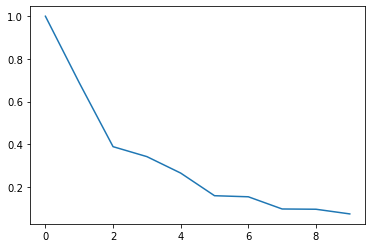

In [12]:
plt.plot(np.sort(calc_loadings(kcav))[::-1])

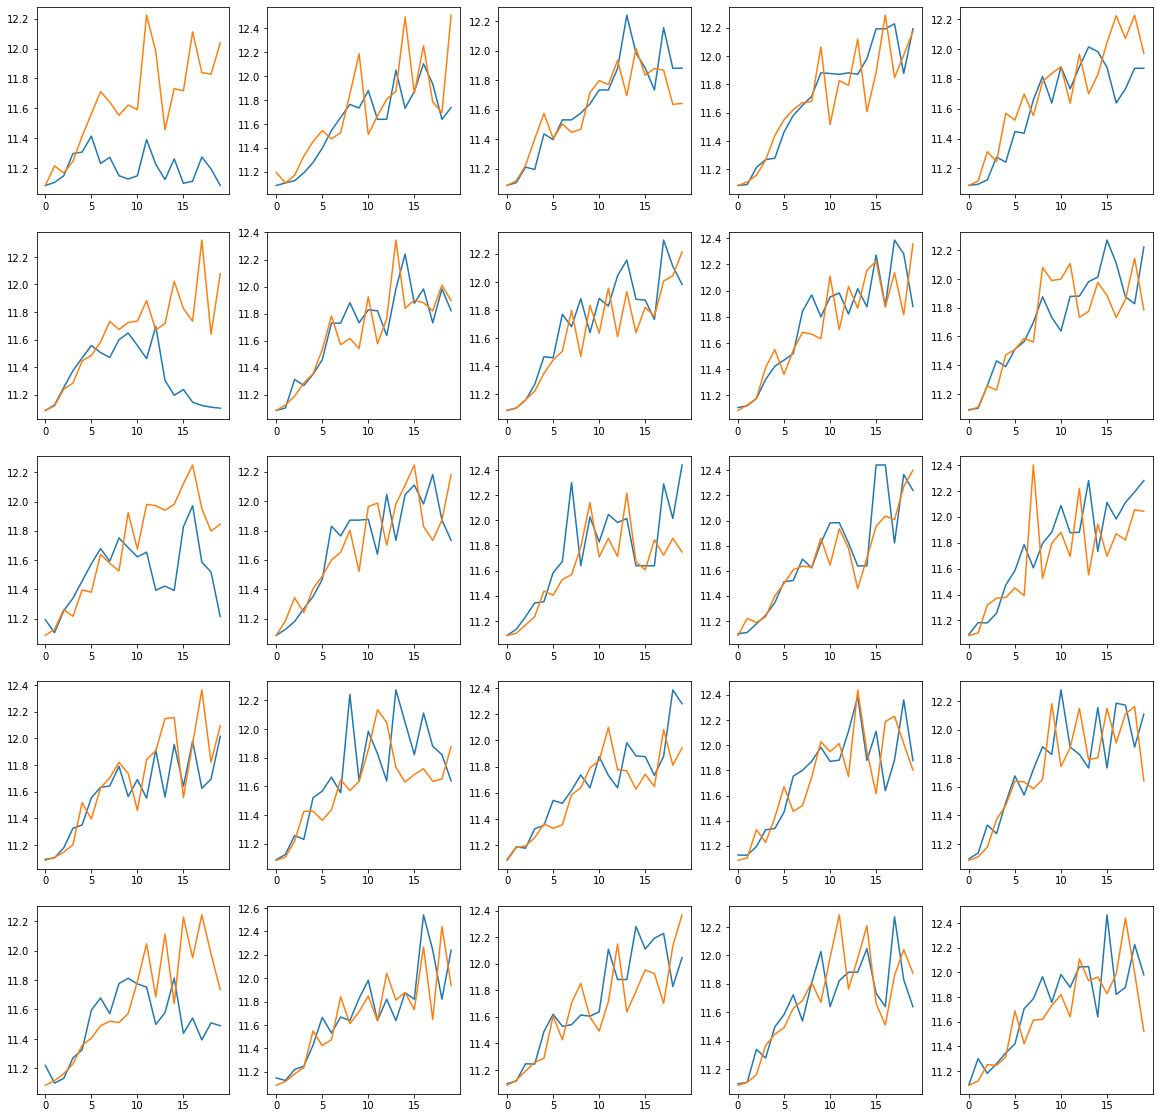

In [13]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
for i in range(rho1.size):
    for j in range(rho2.size):
        ax[i, j].plot(mmse_loss[:, i, j, 0])
        ax[i, j].plot(mmse_loss[:, i, j, 1])

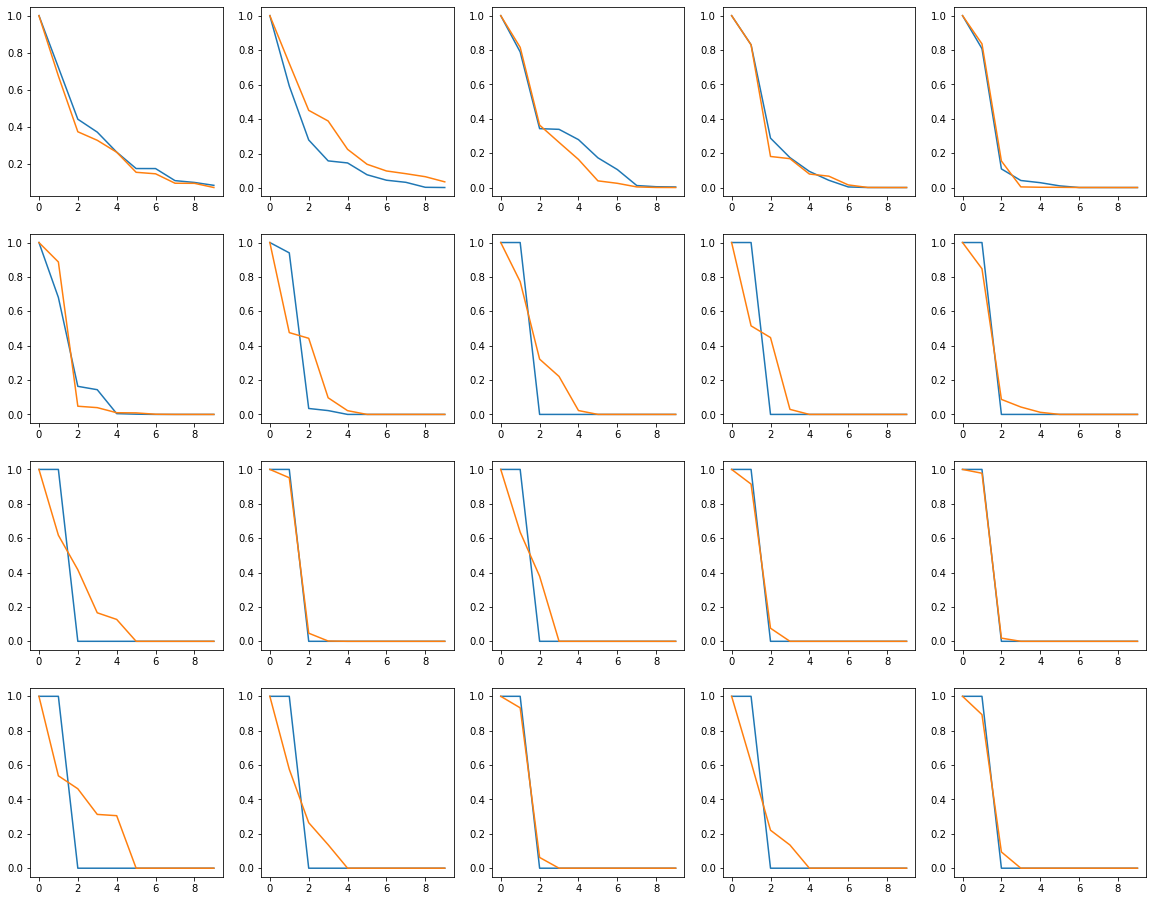

In [14]:
fig, ax = plt.subplots(4, 5, figsize=(20, 16))
for i in range(alpha.size):
    a = ax[np.unravel_index(i, (4, 5))]
    a.plot(np.sort(loadings[i, 2, 2, 0, :])[::-1])
    a.plot(np.sort(loadings[i, 2, 2, 1, :])[::-1])

Text(0.5, 1.0, 'alpha = 0.947368')

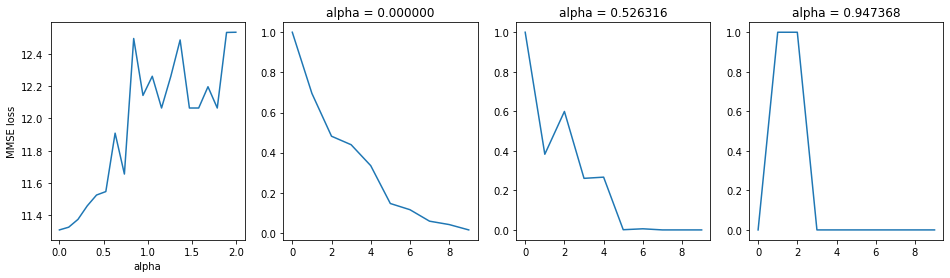

In [27]:
# Summary plot: Loss as a function of alpha, and then loadings
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(alpha, mmse_loss[:, 2, 2])
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('MMSE loss')
ordering = np.argsort(loadings[0, 2, 2])[::-1]
ax[1].plot(loadings[0, 2, 2][ordering])
ax[1].set_title('alpha = %f' % alpha[0])
ax[2].plot(loadings[5, 2, 2][ordering])
ax[2].set_title('alpha = %f' % alpha[5])
ax[3].plot(loadings[9, 2, 2][ordering])
ax[3].set_title('alpha = %f' % alpha[9])

In [19]:
import pickle

In [20]:
with open('synthetic_skca_test.dat', 'wb') as f:
    f.write(pickle.dumps(mmse_loss))
    f.write(pickle.dumps(loadings))

### Applied to Sabes Lab Data

In [9]:
import sys
sys.path.append('/home/akumar/nse/neural_control')
from utils import calc_loadings

In [10]:
from loaders import load_sabes
sabes_files = glob('/mnt/Secondary/data/sabes/indy*')

In [25]:
# These loadings need to correlate with something....my best guess is to try (1) DI between M1/S1 and (2) eDCA/BSSID between M1 and behavior

In [7]:
alpha = np.linspace(0, 2, 20)
rho1 = np.linspace(1, 20, 5)
rho2 = np.linspace(1, 20, 5)

results = {}
for h, data_file in tqdm(enumerate(sabes_files)):
    dat = load_sabes(data_file)
    y = np.squeeze(dat['spike_rates'])
    kcamodel = KCA(d=2, T=3)
    kcamodel.estimate_data_statistics(y, 5)
    kcav, kca_mmse = kcamodel._fit_projection()
    mmse_loss = np.zeros((alpha.size, rho1.size, rho2.size, 2))
    loadings = np.zeros((alpha.size, rho1.size, rho2.size, 2, y.shape[1]))
    for i, alpha_ in tqdm(enumerate(alpha)):
        for j, rho1_ in enumerate(rho1):
            for k, rho2_ in enumerate(rho2):
                skca = SKCA(d=2, T=3, verbose=False, alpha=alpha_, rho1=rho1_, rho2=rho2_, 
                            ADMM_iterations=200)            

                # Alternatively using direct descent
                skca2 = SKCA(d=2, T=3, verbose=False, alpha=alpha_, opt_method='direct')
                skca.cross_covs = kcamodel.cross_covs
                skca2.cross_covs = kcamodel.cross_covs
                V, W, U, L1, L2, loss_series = skca._fit_projection()
                mmse_loss[i, j, k, 0] = loss_series[-1]
                loadings[i, j, k, 0] = calc_loadings(V.detach().numpy())
                
                V, loss_series = skca2._fit_projection()
                mmse_loss[i, j, k, 1] = loss_series[-1]
                loadings[i, j, k, 1] = calc_loadings(V)

    results[data_file] = {}
    results[data_file]['kcav'] = kcav
    results[data_file]['kca_mmse'] = kca_mmse
    results[data_file]['mmse_loss'] = mmse_loss
    results[data_file]['loadings'] = loadings

0it [00:00, ?it/s]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.76s/it]
20it [27:25, 82.29s/it] 
1it [27:30, 1650.92s/it]

Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.82s/it]
20it [27:37, 82.86s/it]
2it [55:25, 1665.11s/it]

Processing spikes


100%|██████████| 1/1 [00:23<00:00, 23.35s/it]
20it [27:32, 82.65s/it]
3it [1:23:23, 1670.62s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.81s/it]
20it [24:47, 74.37s/it]
4it [1:48:15, 1600.33s/it]

Processing spikes


100%|██████████| 1/1 [00:31<00:00, 31.42s/it]
20it [27:25, 82.26s/it]
5it [2:16:13, 1628.20s/it]

Processing spikes


100%|██████████| 1/1 [00:13<00:00, 13.80s/it]
20it [22:03, 66.19s/it]
6it [2:38:31, 1529.56s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.64s/it]
20it [25:03, 75.16s/it]
7it [3:03:38, 1522.26s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]
20it [23:31, 70.58s/it]
8it [3:27:14, 1488.23s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.36s/it]
20it [24:40, 74.01s/it]
9it [3:51:58, 1487.19s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.88s/it]
20it [24:13, 72.66s/it]
10it [4:16:16, 1478.00s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.51s/it]
20it [23:40, 71.01s/it]
11it [4:40:00, 1461.49s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.75s/it]
20it [25:39, 76.99s/it]
12it [5:05:45, 1486.88s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.70s/it]
20it [24:34, 73.72s/it]
13it [5:30:24, 1484.62s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.44s/it]
20it [26:49, 80.48s/it]
14it [5:57:21, 1524.43s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.92s/it]
20it [23:59, 71.99s/it]
15it [6:21:26, 1500.50s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.87s/it]
20it [26:34, 79.71s/it]
16it [6:48:05, 1530.27s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.46s/it]
20it [24:05, 72.28s/it]
17it [7:12:16, 1506.26s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.86s/it]
20it [26:05, 78.27s/it]
18it [7:38:26, 1525.63s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.67s/it]
20it [24:10, 72.52s/it]
19it [8:02:42, 1504.54s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.50s/it]
20it [25:49, 77.46s/it]
20it [8:28:37, 1519.74s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.92s/it]
20it [24:13, 72.67s/it]
21it [8:52:58, 1502.04s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.24s/it]
20it [24:14, 72.72s/it]
22it [9:17:17, 1489.10s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.27s/it]
20it [23:13, 69.67s/it]
23it [9:40:36, 1462.07s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.43s/it]
20it [22:45, 68.25s/it]
24it [10:03:26, 1434.71s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.69s/it]
20it [22:16, 66.84s/it]
25it [10:25:49, 1407.15s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.61s/it]
20it [24:09, 72.48s/it]
26it [10:50:05, 1421.67s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.90s/it]
20it [26:28, 79.44s/it]
27it [11:16:41, 1474.01s/it]

Processing spikes


100%|██████████| 1/1 [00:07<00:00,  7.73s/it]
20it [24:22, 73.12s/it]
28it [11:41:12, 1502.58s/it]


In [4]:
import pickle

In [5]:
# with open('sabes_skca_test.dat', 'wb') as f:
#     f.write(pickle.dumps(results))
with open('sabes_skca_test.dat', 'rb') as f:
    results = pickle.load(f)

In [10]:
# Plots to make: 
# (1) Averaged loss comparison with the baseline
# (2) Examples of compressed loadings

In [11]:
mmse_loss.shape

(20, 5, 5, 2)

In [13]:
mmse_loss = results[sabes_files[0]]['mmse_loss']

In [14]:
mmse_loss_avg = np.zeros((len(sabes_files),) + mmse_loss.shape)
# Normalize 
for i, data_file in enumerate(sabes_files):
    mmse_loss_avg[i] = np.divide(results[data_file]['mmse_loss'], results[data_file]['mmse_loss'][0]) 


In [15]:
mmse_loss_avg.shape

(28, 20, 5, 5, 2)

In [6]:
import matplotlib.pyplot as plt

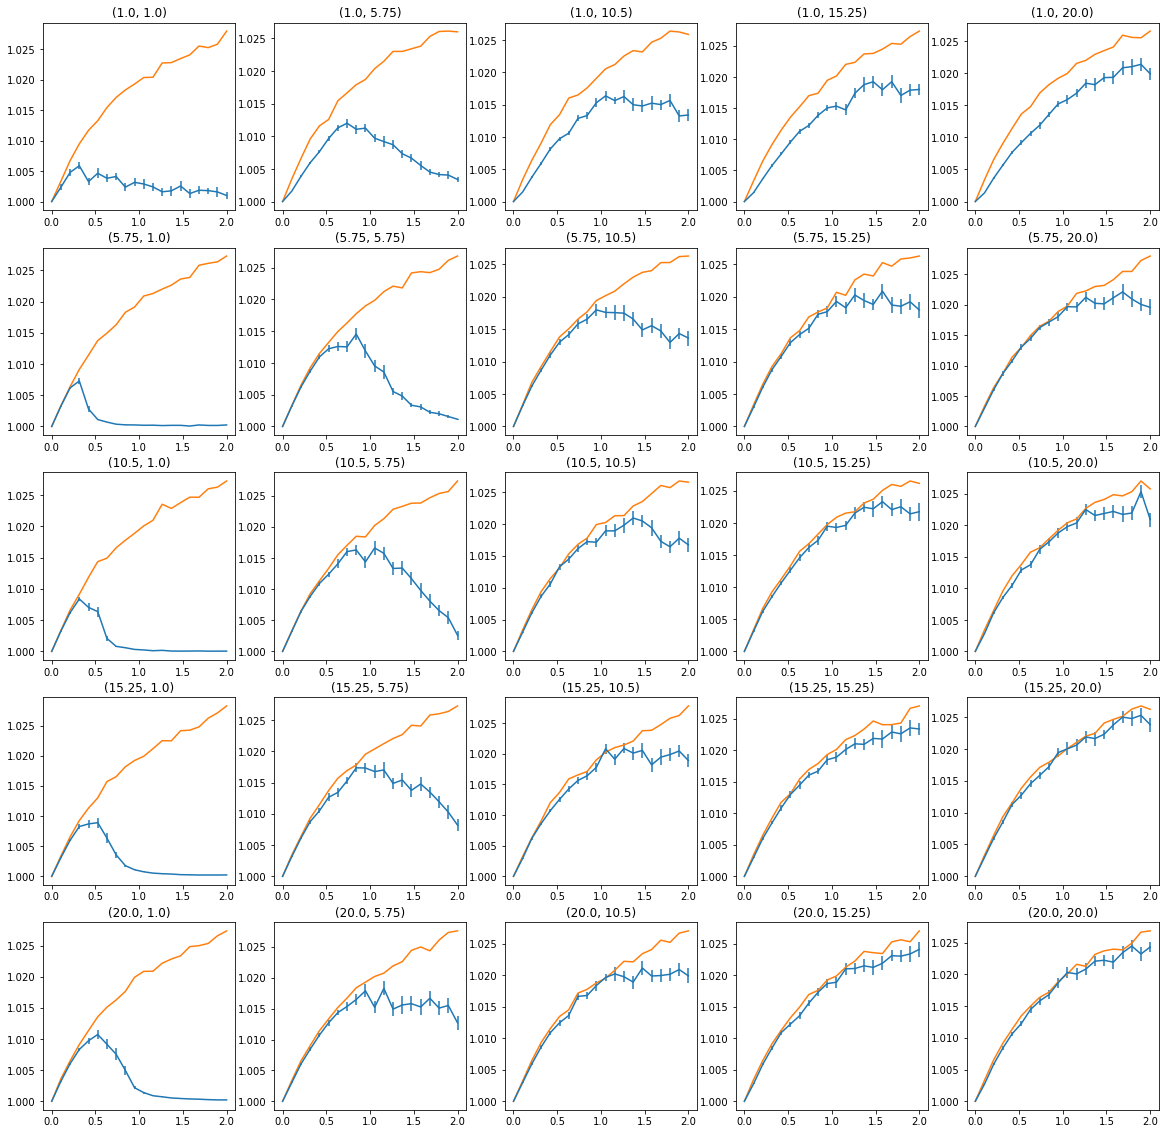

In [25]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
for i in range(5):
    for j in range(5):
        #ax[i, j].plot(np.mean(mmse_loss_avg[..., i, j, 0], axis=0))
        ax[i, j].errorbar(alpha, np.mean(mmse_loss_avg[..., i, j, 0], axis=0), 
                          yerr=np.std(mmse_loss_avg[..., i, j, 0], axis=0)/np.sqrt(28))
        ax[i, j].plot(alpha, np.mean(mmse_loss_avg[..., i, j, 1], axis=0))
        ax[i, j].set_title((rho1[i], rho2[j]))

In [7]:
alpha = np.linspace(0, 2, 20)

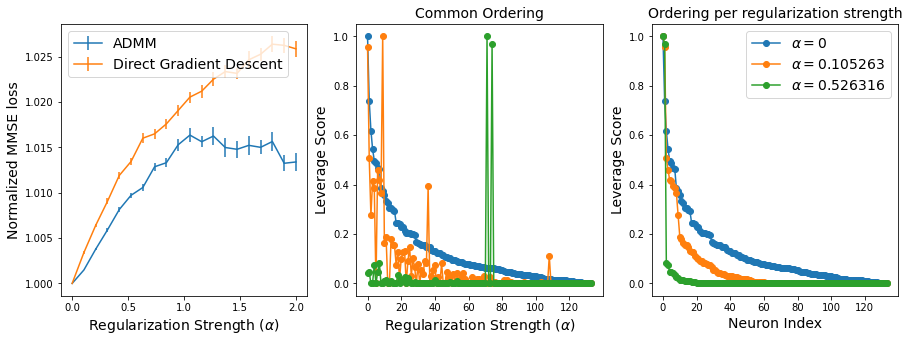

In [18]:
# Compress into a single plot
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].errorbar(alpha, np.mean(mmse_loss_avg[..., 0, 2, 0], axis=0), 
                    yerr=np.std(mmse_loss_avg[..., 0, 2, 0], axis=0)/np.sqrt(28))
ax[0].errorbar(alpha, np.mean(mmse_loss_avg[..., 0, 2, 1], axis=0), 
                    yerr=np.std(mmse_loss_avg[..., 0, 2, 1], axis=0)/np.sqrt(28))
ax[0].set_xlabel('Regularization Strength ' + r'$(\alpha)$', fontsize=14)
ax[0].set_ylabel('Normalized MMSE loss', fontsize=14)
ax[0].legend(['ADMM', 'Direct Gradient Descent'], fontsize=14, loc='upper left')

ordering = np.argsort(results[sabes_files[6]]['loadings'][0, 3, 2, 0, :])[::-1]
ax[1].plot(results[sabes_files[6]]['loadings'][0, 3, 2, 0, ordering], '-o')
ax[1].plot(results[sabes_files[6]]['loadings'][1, 3, 2, 0, ordering], '-o')
ax[1].plot(results[sabes_files[6]]['loadings'][5, 3, 2, 0, ordering], '-o')

ax[1].set_xlabel('Neuron Index', fontsize=14)
ax[1].set_ylabel('Leverage Score', fontsize=14)
ax[1].set_xlabel('Regularization Strength ' + r'$(\alpha)$', fontsize=14)
ax[1].set_title('Common Ordering', fontsize=14)

ax[2].plot(np.sort(results[sabes_files[6]]['loadings'][0, 3, 2, 0, ordering])[::-1], '-o')
ax[2].plot(np.sort(results[sabes_files[6]]['loadings'][1, 3, 2, 0, ordering])[::-1], '-o')
ax[2].plot(np.sort(results[sabes_files[6]]['loadings'][5, 3, 2, 0, ordering])[::-1], '-o')
ax[2].set_xlabel('Neuron Index', fontsize=14)
ax[2].set_ylabel('Leverage Score', fontsize=14)
ax[2].set_title('Ordering per regularization strength', fontsize=14)
ax[2].legend([r'$\alpha=0$', r'$\alpha=%2f$' % alpha[1], r'$\alpha=%2f$' % alpha[5]], fontsize=14)
fig.savefig('skca_fig.pdf', bbox_inches='tight', pad_inches=0)

In [26]:
results[data_file]['loadings'].shape

(20, 5, 5, 2, 138)

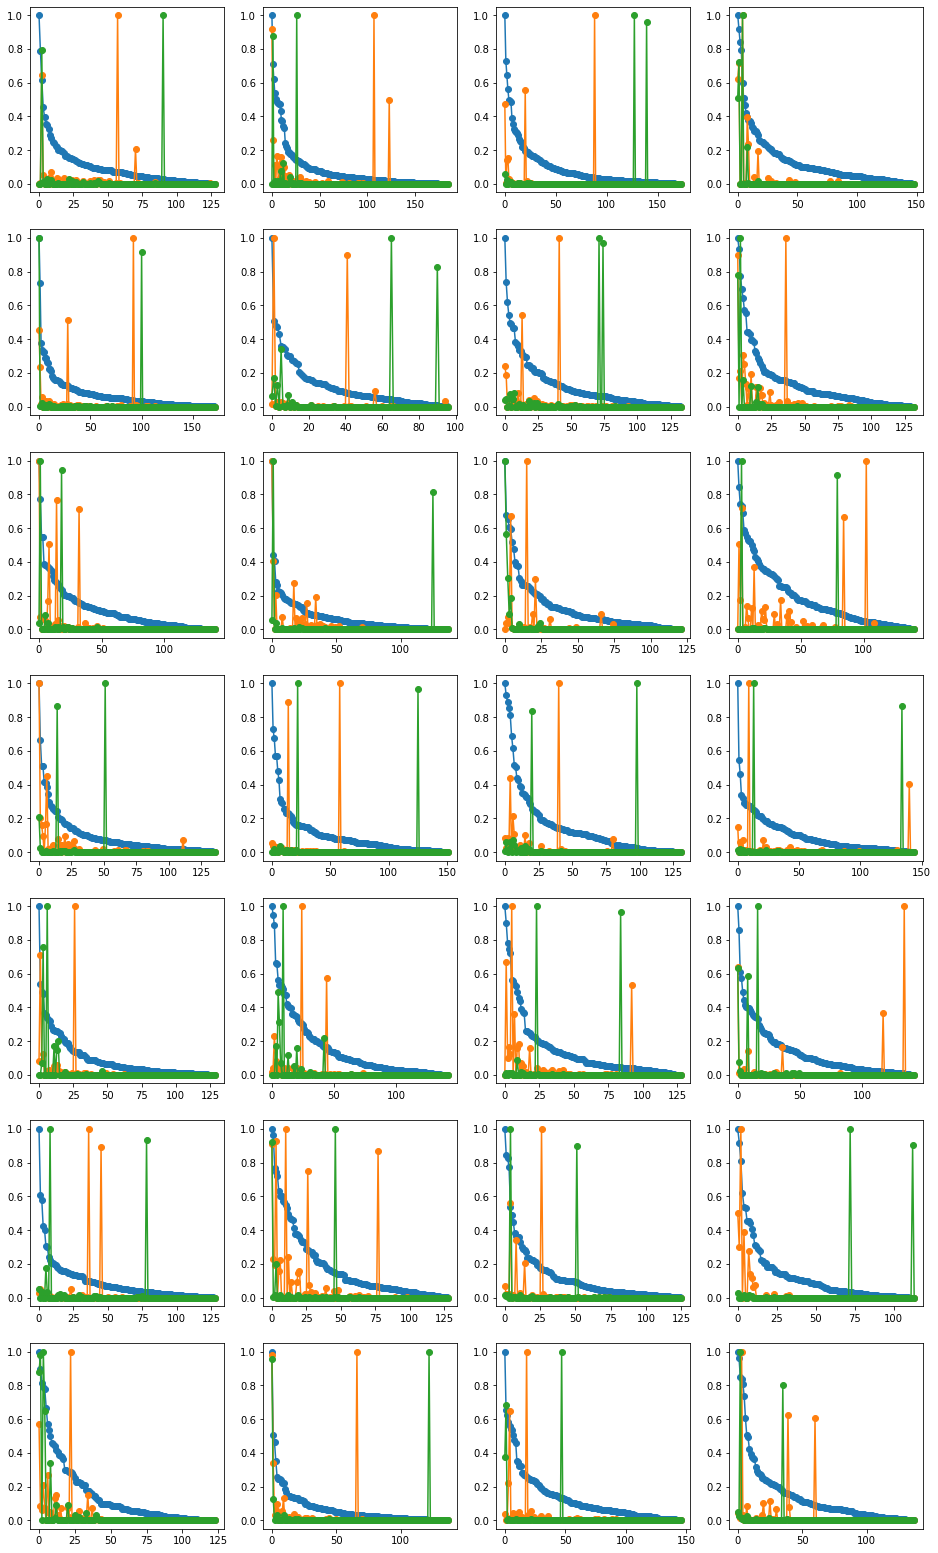

In [34]:
# Choose 10.5 10.5
# Plot loadings across data files
fig, ax = plt.subplots(7, 4, figsize=(16, 28))
for i in range(len(sabes_files)):
    a = ax[np.unravel_index(i, (7, 4))]
    ordering = np.argsort(results[sabes_files[i]]['loadings'][0, 3, 2, 0, :])[::-1]
    a.plot(results[sabes_files[i]]['loadings'][0, 3, 2, 0, ordering], '-o')
    a.plot(results[sabes_files[i]]['loadings'][2, 3, 2, 0, ordering], '-o')
    a.plot(results[sabes_files[i]]['loadings'][5, 3, 2, 0, ordering], '-o')

In [ ]:
# Plot #1 